In [3]:
import os
colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Tesis/tesis/generative')
else:
    os.chdir('../generative')

In [4]:
import librosa
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython.display import Audio

import os
import sys
import json

from sampling.sampling_utils import get_vae_sample, get_diffusion_sample

sys.path.append(os.path.abspath("../model_utils"))
from model_utils.diffusion_utils import calc_diffusion_hyperparams

import torch
import pickle

# plt.rcParams.update({'font.size': 12})


In [4]:
def load_audio(path, verbose=False):
    audio, sr = librosa.load(path, sr=16_000)

    return audio, sr

def make_plot(audio_array, sample_rate):
    plt.figure().set_figwidth(14)
    librosa.display.waveshow(audio_array, sr=sample_rate)

    ## Espectograma
    D = librosa.stft(audio_array)
    # Convert the complex-valued result to magnitude
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    # Display the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
    # plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

# Comparacion local

In [ ]:
subfigs[0].set_in_layout?

Object `set_in_layout` not found.


In [ ]:
# fig = plt.figure(layout='constrained', figsize=(10, 4))
# subfigs = fig.subfigures(1, 2, wspace=0.07)
# dir(subfigs[0])

In [5]:
def plot_local(dict_samples):
    num_columns = len(dict_samples)
    # Assuming your data is in a format compatible with plotting (e.g., lists of values)
    fig = plt.figure(layout='constrained', figsize=(20, 8))
    subfigs = fig.subfigures(1, num_columns, wspace=0.01, width_ratios=[1, 1])
    for j, key in enumerate(dict_samples):
        axes = subfigs[j].subplots(2, 1)
        subfigs[j].set_facecolor('0.75')
        # subfigs[j].tight_layout(pad=0.5)
        audio = dict_samples[key]

        color = 'b' if j == 0 else 'purple'
        librosa.display.waveshow(audio, ax=axes[0], axis='off', color=color, linewidth=1, alpha=0.7)
        axes[0].set_title(key, fontsize=23, fontfamily='serif')
        # axes[1].set_ylabel("Hz", fontsize=17, fontfamily='serif')
        axes[0].tick_params(axis='y', labelsize=15)

        D = librosa.stft(audio)
        # Convert the complex-valued result to magnitude
        S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
        # Display the spectrogram
        librosa.display.specshow(S_db, x_axis="time", y_axis='hz', ax=axes[1])
        axes[1].xaxis.set_major_formatter('{x:.1f}')
        axes[1].set_ylabel("Hz", fontsize=17, fontfamily='serif')
        axes[1].set_xlabel("Time", fontsize=17, fontfamily='serif')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)



    plt.show()

## Real

In [6]:
dict_local = {}

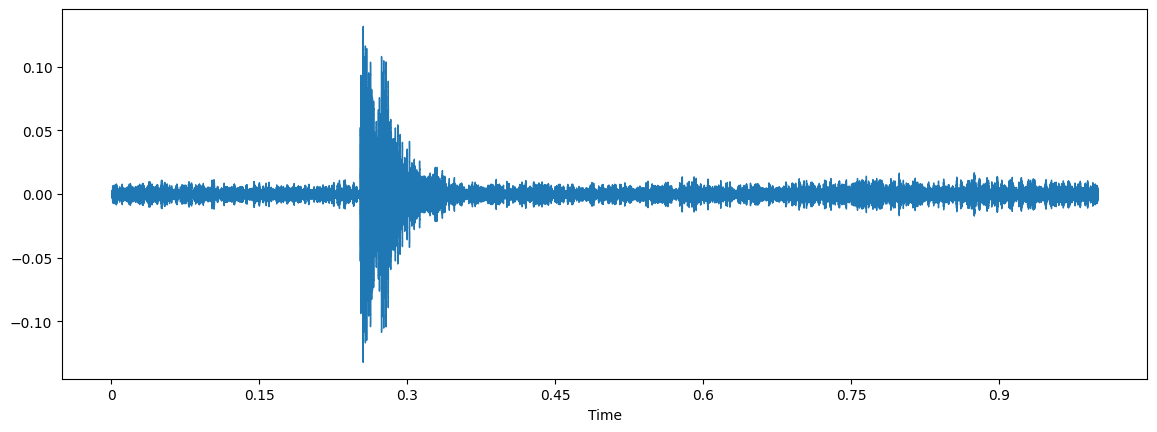

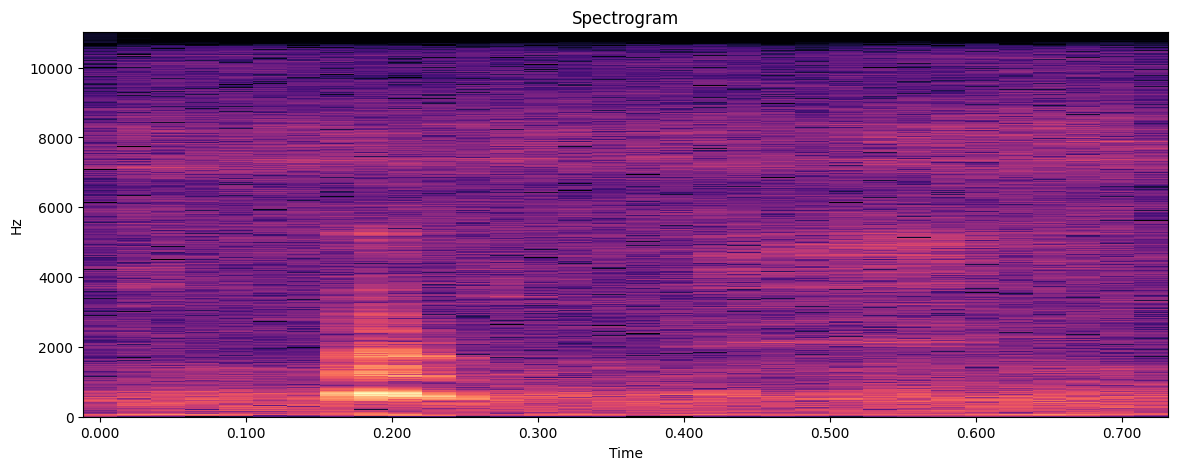

In [7]:
ROOT_PATH = '../data/train_gen/BOAFAB/'
list_of_audios = os.listdir(ROOT_PATH)
audio, sr = load_audio(ROOT_PATH + list_of_audios[10_000])


dict_local['Ground Truth'] = audio
make_plot(audio, sr)
Audio(data=audio, rate=sr)

## Diffusion

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_diff = torch.load(f'./models_trained/DIFFUSION/75_DIFFUSION_model.pth', map_location=device)
model_diff.eval();

In [ ]:
from sampling.sampling_utils import get_diffusion_sample
import sys
sys.path.append(os.path.abspath("../model_utils"))
from model_utils.diffusion_utils import calc_diffusion_hyperparams
with open('./config.json', 'r') as f:
    config = json.load(f)
    sr = config['audio_config']['sample_rate']

diffusion_config = config['diffusion_config']
diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)
samples_diff = get_diffusion_sample(model_diff, (10, 1, sr), diffusion_hyperparams)

In [ ]:
diff_audio = samples_diff.cpu().numpy()[5][0]

dict_local['Diffusion Sample'] = diff_audio
make_plot(diff_audio, sr)
Audio(data=diff_audio, rate=sr)

## VAE

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vae = torch.load(f'./models_trained/VAE/70_VAE_model.pth', map_location=device)
model_vae.eval();

In [ ]:
from sampling.sampling_utils import get_vae_sample
samples_vae = get_vae_sample(model_vae, 1)

In [ ]:
vae_audio = samples_vae.cpu().numpy()[1][0]

dict_local['VAE Sample'] = vae_audio
# make_plot(diff_audio, sr)
# Audio(data=diff_audio, rate=sr)

In [ ]:
dict_local

In [ ]:
import pickle
with open('../figuras/local.pickle', 'wb') as f:
    pickle.dump(dict_local, f)

## Cargar y dibujar

In [8]:
import pickle
with open('../figuras/local.pickle', 'rb') as f:
    dict_local = pickle.load(f)

dict_local['Generated Sample'] = dict_local['Diffusion Sample']
del dict_local['Diffusion Sample']

In [14]:
from  scipy.io import wavfile 

wavfile.write(r'C:\Users\snung\Documents\abc2.wav', sr, dict_local['Ground Truth'])

In [12]:
Audio(data=dict_local['Generated Sample'], rate=sr)

In [10]:
dict_local

{'Ground Truth': array([ 0.03396606,  0.03045654,  0.02664185, ..., -0.01852417,
        -0.01989746, -0.02096558], dtype=float32),
 'Generated Sample': array([ 0.00209832,  0.00446363,  0.00223218, ..., -0.00671214,
        -0.00389822, -0.00241379], dtype=float32)}

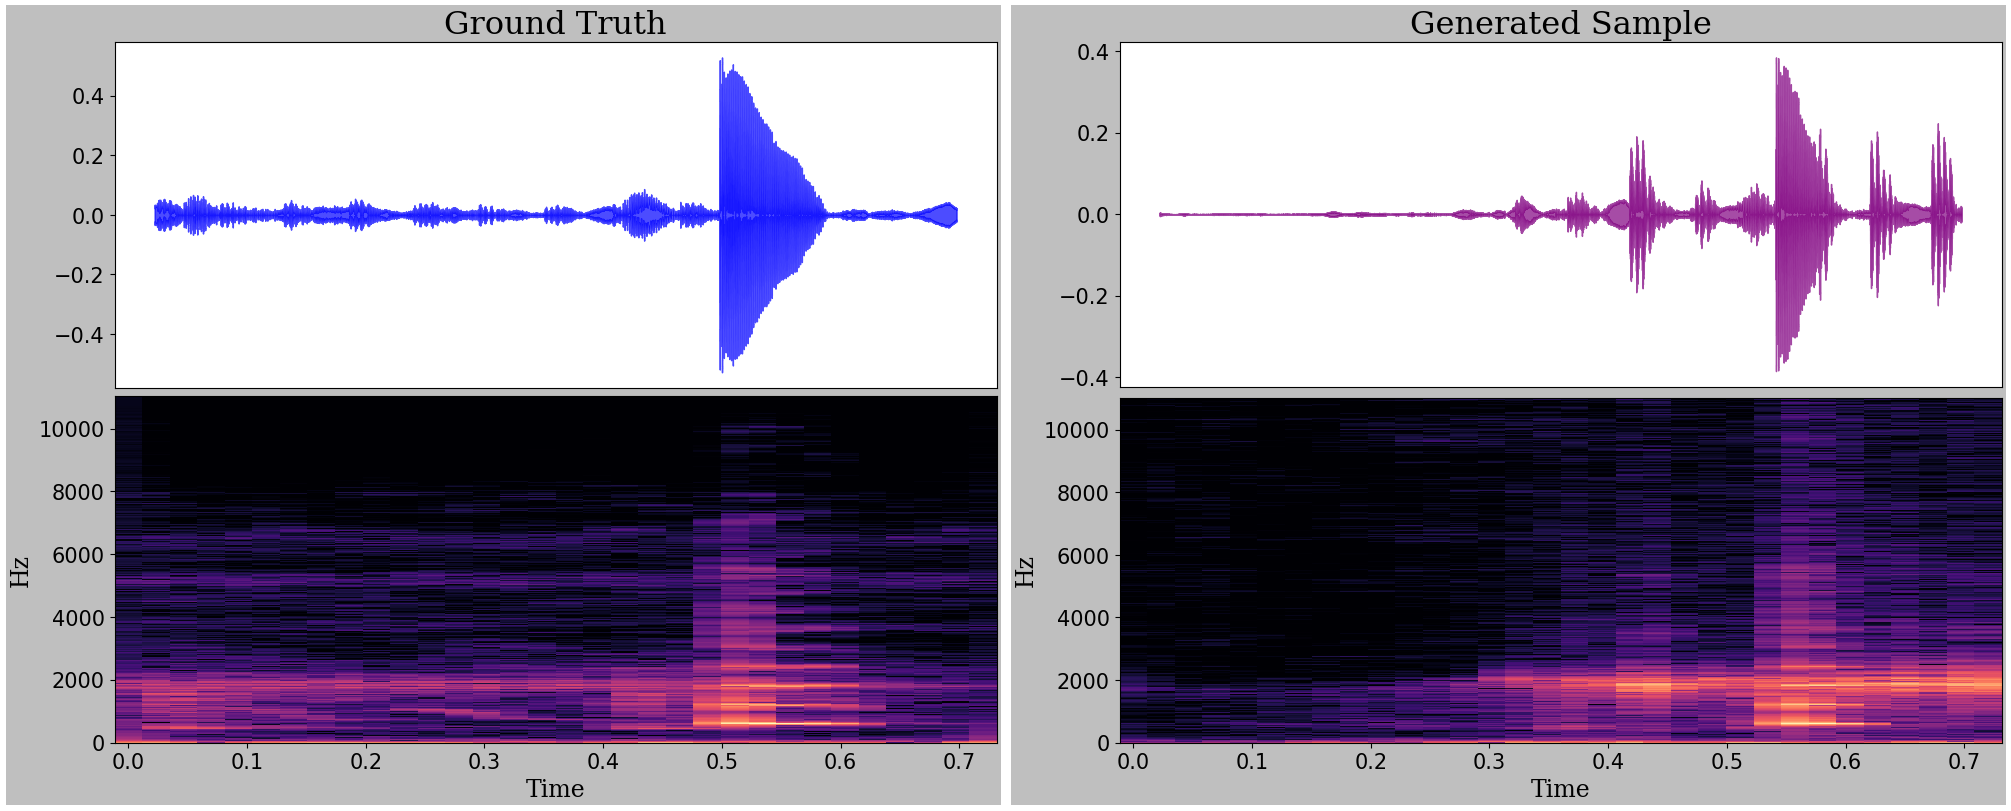

In [9]:
plot_local(dict_local)

# Proceso de difusion

In [11]:
def plot_process(dict_samples, img_idx=0, save_path=None):
    num_columns = len(dict_samples)
    # Assuming your data is in a format compatible with plotting (e.g., lists of values)
    fig, axes = plt.subplots(2, num_columns, figsize=(35, 9), width_ratios=[1]*num_columns )
    for j, key in enumerate(dict_samples):
        audio = dict_samples[key].cpu().numpy()[img_idx][0]
        if save_path is not None:
            from  scipy.io import wavfile 

            wavfile.write(f'C:/Users/snung/Documents/{j}.wav', 16000, audio)
        librosa.display.waveshow(audio, ax=axes[0, j], axis='off', color='purple', linewidth=1, alpha=0.7)
        axes[0, j].set_title(f"$t = {key}$", fontsize=20, fontfamily='serif')
        axes[0, j].tick_params(axis='y', labelsize=15)

        D = librosa.stft(audio)
        # Convert the complex-valued result to magnitude
        S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
        # Display the spectrogram
        y_axis = 'off' if j > 0 else 'hz'
        librosa.display.specshow(S_db, x_axis="time", y_axis=y_axis, ax=axes[1, j])
        axes[1, j].tick_params(axis='x', labelsize=15)

        axes[1, j].xaxis.set_major_formatter('{x:.1f}')
        if j == 0:
            axes[1, j].set_ylabel("Hz", fontsize=20, fontfamily='serif')
            axes[1, j].tick_params(axis='y', labelsize=15)
        if j==3:
            axes[1, j].set_xlabel("Time", fontsize=20, fontfamily='serif')
        else:
            axes[1, j].set_xlabel("")


    plt.show()

## Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_diff = torch.load(f'./models_trained/DIFFUSION/75_DIFFUSION_model.pth', map_location=device)
model_diff.eval();

In [ ]:
from sampling.sampling_utils import get_diffusion_sample_interim_steps
import sys
sys.path.append(os.path.abspath("../model_utils"))
from model_utils.diffusion_utils import calc_diffusion_hyperparams
with open('./config.json', 'r') as f:
    config = json.load(f)
    sr = config['audio_config']['sample_rate']

diffusion_config = config['diffusion_config']
diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)
interim_diff = get_diffusion_sample_interim_steps(
    model_diff,
    (20, 1, sr),
    diffusion_hyperparams,
    list_steps=[199, 100, 50, 10, 7, 4, 2, 0])

In [ ]:

interim_diff = {key: interim_diff[key].cpu() for key in interim_diff}
import pickle
with open('../figuras/diffusion_process.pickle', 'wb') as f:
    pickle.dump(interim_diff, f)

## Cargar y dibujar

In [9]:
import pickle
with open('../figuras/diffusion_process.pickle', 'rb') as f:
    interim_diff = pickle.load(f)

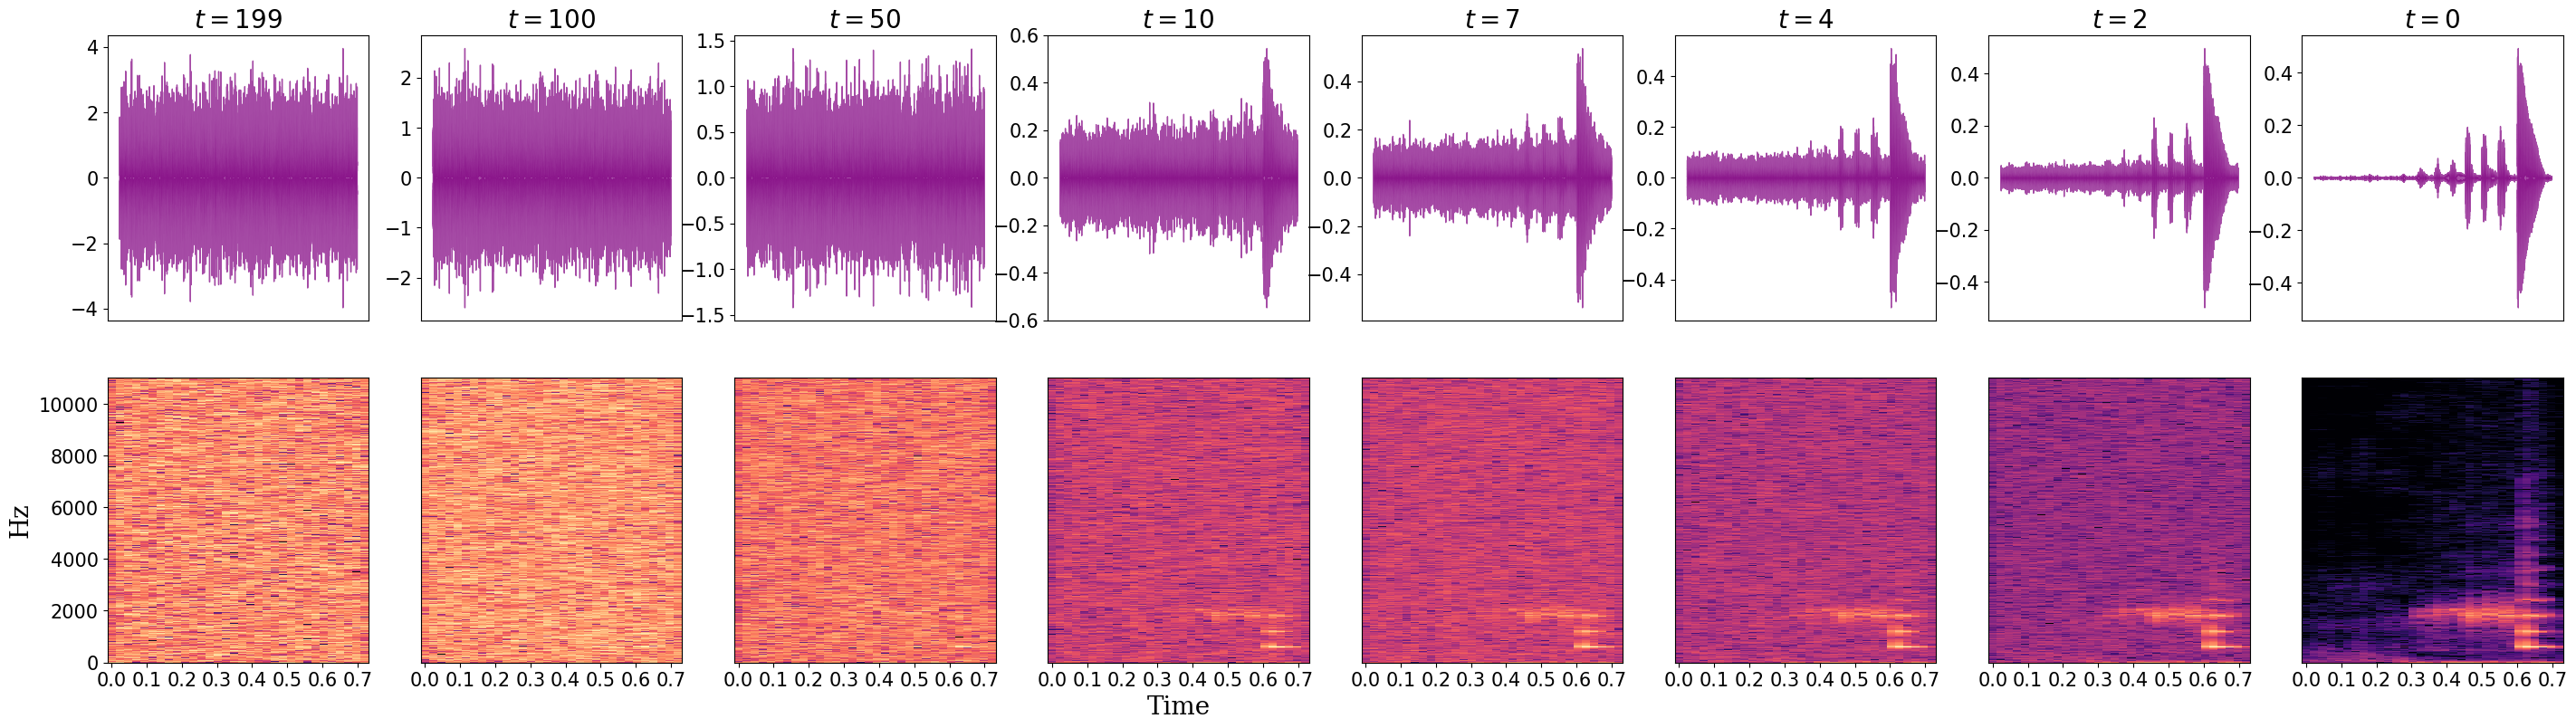

In [12]:
# 2, 4
plot_process(interim_diff, img_idx:=2, save_path=1)

In [ ]:
audio = interim_diff[0].cpu().numpy()[4][0]

make_plot(audio, sr)
Audio(data=audio, rate=sr)

# Loss Function

## Run with GPU

In [ ]:
from collections import namedtuple
import json
import training_loss

import torch
from dataset_manager import GenerativeAIDataset
from torch.utils.data import DataLoader

from transformation.data_preprocessing import get_data_composing

from tqdm import tqdm
import torch

Args = namedtuple('Args', [
    'batch_size',
    'max_epochs',
    'model',
    'config'
])

args = Args(
    batch_size=64,
    # learning_rate=1e-3,
    max_epochs=1,
    model='DIFFUSION',
    config='./config.json')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
with open(args.config, 'r') as f:
    config = json.load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = args.batch_size
model_name = args.model

sr = config['audio_config']['sample_rate']

data_processing = get_data_composing(model_name, config)
test_dataset = GenerativeAIDataset('../data/train_gen',
                            data_processing,
                            class_c='BOAFAB',
                            expand_data=1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=False, shuffle=True)

# model = models.create_model(model_name, config=config).to(device)
training_loss_function = training_loss.get_loss_train(model_name, general_config=config)

In [ ]:
@torch.no_grad()
def test(model_name, model):

    model.eval()  # Set model to training mode (lo dejo si hago validación)

    running_loss = 0.0
    pbar = tqdm(test_dataloader,
            unit="audios",
            unit_scale=test_dataloader.batch_size,
            desc=f'Model: {model_name}')
    for step, batch in enumerate(pbar):
        batch = batch['samples'].to(device)
        loss = training_loss_function(model, batch)

        running_loss += loss.item()
        pbar.set_postfix({
            'loss': "%.05f" % (running_loss / (step + 1))
        })

    loss_model = running_loss / len(test_dataloader)

    return loss_model

In [ ]:
trained_models = os.listdir('./models_trained/DIFFUSION/')
dict_result = {}
for model_epoch in list(range(0, 80, 5)):
    model_name = f'{model_epoch}_DIFFUSION_model.pth'

    model_diff = torch.load(f'./models_trained/DIFFUSION/{model_name}', map_location=device)

    # loss_model = test(model_name, model_diff).cpu()
    print(f'--------- {model_name}')
    diffusion_config = config['diffusion_config']
    diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)
    sample_diff = get_diffusion_sample(model_diff, (1, 1, sr), diffusion_hyperparams)
    sample_diff = sample_diff.cpu()

    dict_result[model_epoch] = sample_diff

    del model_diff
    torch.cuda.empty_cache()

In [ ]:
dict_result

In [ ]:
import pickle
with open('../figuras/loss.pickle', 'wb') as f:
    pickle.dump(dict_result, f)

##  Get trining loss from prompt

In [ ]:
# loss_values (output of cell)
import re

output_text = """
Epoca 0: 100%|██████████| 14656/14656 [23:40<00:00, 10.32audios/s, loss=0.02883]
Epoca 1: 100%|██████████| 14656/14656 [15:57<00:00, 15.31audios/s, loss=0.01204]
Epoca 2: 100%|██████████| 14656/14656 [15:57<00:00, 15.31audios/s, loss=0.03995]
Epoca 3: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.01091]
Epoca 4: 100%|██████████| 14656/14656 [15:57<00:00, 15.31audios/s, loss=0.01184]
Epoca 5: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00832]
Epoca 6: 100%|██████████| 14656/14656 [15:57<00:00, 15.31audios/s, loss=0.00883]
Epoca 7: 100%|██████████| 14656/14656 [15:58<00:00, 15.30audios/s, loss=0.00769]
Epoca 8: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00726]
Epoca 9: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00691]
Epoca 10: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00655]
Epoca 11: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00634]
Epoca 12: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00642]
Epoca 13: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00598]
Epoca 14: 100%|██████████| 14656/14656 [15:58<00:00, 15.30audios/s, loss=0.00557]
Epoca 15: 100%|██████████| 14656/14656 [15:57<00:00, 15.30audios/s, loss=0.00573]
Epoca 16: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00564]
Epoca 17: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00548]
Epoca 18: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00520]
Epoca 19: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00526]
Epoca 20: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00565]
Epoca 21: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00536]
Epoca 22: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00505]
Epoca 23: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00481]
Epoca 24: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00479]
Epoca 25: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00483]
Epoca 26: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00499]
Epoca 27: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00471]
Epoca 28: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00465]
Epoca 29: 100%|██████████| 14656/14656 [15:54<00:00, 15.35audios/s, loss=0.00480]
Epoca 30: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00457]
Epoca 31: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00458]
Epoca 32: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00452]
Epoca 33: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00430]
Epoca 34: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00445]
Epoca 35: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00435]
Epoca 36: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00426]
Epoca 37: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00443]
Epoca 38: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00429]
Epoca 39: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00455]
Epoca 40: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00436]
Epoca 41: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00428]
Epoca 42: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00410]
Epoca 43: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00412]
Epoca 44: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00405]
Epoca 45: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00424]
Epoca 46: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00432]
Epoca 47: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00395]
Epoca 48: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00440]
Epoca 49: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00402]
Epoca 50: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00398]
Epoca 51: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00420]
Epoca 52: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00391]
Epoca 53: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00377]
Epoca 54: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00401]
Epoca 55: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00409]
Epoca 56: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00403]
Epoca 57: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00370]
Epoca 58: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00399]
Epoca 59: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00373]
Epoca 60: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00380]
Epoca 61: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00383]
Epoca 62: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00377]
Epoca 63: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00400]
Epoca 64: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00360]
Epoca 65: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00337]
Epoca 66: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00355]
Epoca 67: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00336]
Epoca 68: 100%|██████████| 14656/14656 [15:56<00:00, 15.32audios/s, loss=0.00351]
Epoca 69: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00349]
Epoca 70: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00327]
Epoca 71: 100%|██████████| 14656/14656 [15:55<00:00, 15.34audios/s, loss=0.00320]
Epoca 72: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00337]
Epoca 73: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00330]
Epoca 74: 100%|██████████| 14656/14656 [15:56<00:00, 15.33audios/s, loss=0.00349]
Epoca 75: 100%|██████████| 14656/14656 [15:55<00:00, 15.33audios/s, loss=0.00357]
Epoca 76:  91%|█████████ | 13288/14656 [14:27<01:29, 15.32audios/s, loss=0.00346]
"""

loss_values = []
for i, line in enumerate(output_text.splitlines()):
    match = re.search(r"loss=([\d\.]+)", line)  # Regular expression to find loss
    if match:
        loss_values.append((i-1, float(match.group(1))))

In [ ]:
def plot_epoch_process(dict_samples, img_idx=0):
    num_columns = len(dict_samples)
    # Assuming your data is in a format compatible with plotting (e.g., lists of values)
    fig, axes = plt.subplots(2, num_columns, figsize=(15, 4))
    for j, key in enumerate(dict_samples):
        audio = dict_samples[key].cpu().numpy()[img_idx][0]

        librosa.display.waveshow(audio, ax=axes[0, j], axis='off', color='purple', linewidth=1, alpha=0.7)
        axes[0, j].set_title(f"Epoch {key}", fontsize=17, fontfamily='serif')

        D = librosa.stft(audio)
        # Convert the complex-valued result to magnitude
        S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
        # Display the spectrogram
        y_axis = 'off' if j > 0 else 'hz'
        librosa.display.specshow(S_db, x_axis="time", y_axis=y_axis, ax=axes[1, j])
        axes[1, j].xaxis.set_major_formatter('{x:.1f}')
        if j == 0 : axes[1, j].set_ylabel("Hz", fontsize=17, fontfamily='serif')
        axes[1, j].set_xlabel("Time", fontsize=15, fontfamily='serif')

    plt.show()

In [ ]:
with open('../figuras/loss.pickle', 'rb') as f:
    dict_result = pickle.load(f)

dict_result = {key: dict_result[key] for key in dict_result if key in [10, 30, 50, 75]}

In [ ]:
dict_result

{10: tensor([[[ 0.0060,  0.0066,  0.0076,  ..., -0.0029,  0.0002,  0.0009]]]),
 30: tensor([[[ 0.0025,  0.0035,  0.0015,  ...,  0.0110,  0.0054, -0.0009]]]),
 50: tensor([[[ 0.0003,  0.0019,  0.0038,  ..., -0.0027, -0.0015, -0.0023]]]),
 75: tensor([[[-0.0002,  0.0013, -0.0007,  ..., -0.0018, -0.0004, -0.0005]]])}

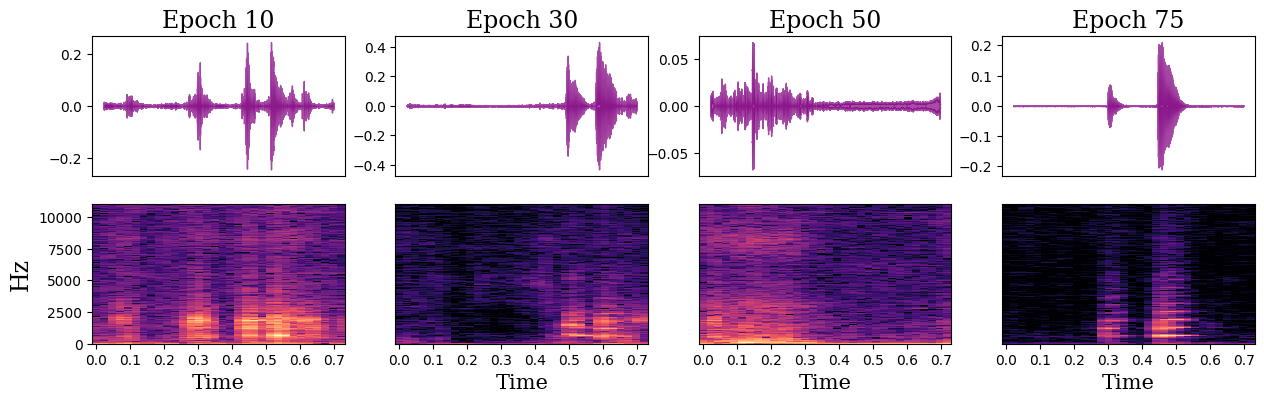

In [ ]:
plot_epoch_process(dict_result)

In [ ]:
# loss_values
loss_plot = [i[1] for i in loss_values]
loss_marks = [i[1] for i in loss_values if i[0] in [10, 30, 50, 75]]

In [ ]:
loss_marks

[0.00655, 0.00457, 0.00398, 0.00357]

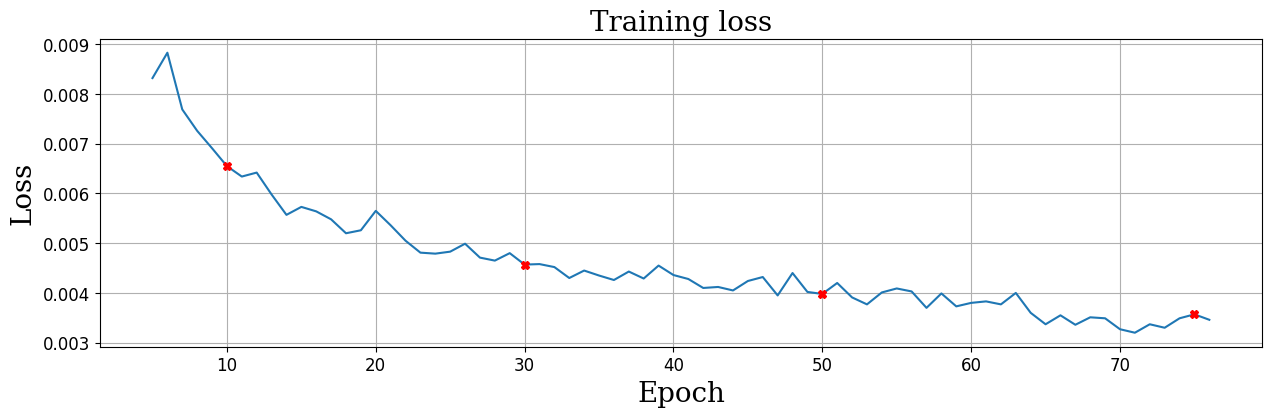

In [ ]:

plt.figure(figsize=(15, 4))
plt.plot(range(5, 77), loss_plot[5:])
plt.plot([10, 30, 50, 75], loss_marks, 'rX')
plt.ylabel('Loss', fontsize=20, fontfamily='serif')
plt.xlabel('Epoch', fontsize=20, fontfamily='serif')
plt.title('Training loss', fontsize=20, fontfamily='serif');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

# Embedding plots

In [ ]:
# del model_diff, samples_diff
torch.cuda.empty_cache()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_diff = torch.load(f'./models_trained/DIFFUSION/75_DIFFUSION_model.pth', map_location=device)
model_diff.eval();

from sampling.sampling_utils import get_diffusion_sample
import sys
sys.path.append(os.path.abspath("../model_utils"))
from model_utils.diffusion_utils import calc_diffusion_hyperparams
with open('./config.json', 'r') as f:
    config = json.load(f)
    sr = config['audio_config']['sample_rate']

diffusion_config = config['diffusion_config']

to_save = {}
for i in range(5):
  diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)
  samples_diff = get_diffusion_sample(model_diff, (50, 1, sr), diffusion_hyperparams)

  sample_diff = samples_diff.cpu()

  to_save[f'{i}_samples_embedding'] = samples_diff

import pickle
with open('../figuras/4000_samples.pickle', 'wb') as f:
    pickle.dump(to_save, f)

begin sampling, total number of reverse steps = 200


Reverse process: 100%|██████████| 200/200 [15:08<00:00,  4.54s/it]


begin sampling, total number of reverse steps = 200


Reverse process: 100%|██████████| 200/200 [15:07<00:00,  4.54s/it]


begin sampling, total number of reverse steps = 200


Reverse process: 100%|██████████| 200/200 [15:07<00:00,  4.54s/it]


begin sampling, total number of reverse steps = 200


Reverse process: 100%|██████████| 200/200 [15:07<00:00,  4.54s/it]


begin sampling, total number of reverse steps = 200


Reverse process: 100%|██████████| 200/200 [15:07<00:00,  4.54s/it]


In [5]:
import pickle
with open('../figuras/4000_samples.pickle', 'rb') as f:
    samples = pickle.load(f)

In [6]:
import pickle
with open('../figuras/4000_samples.pickle', 'wb') as f:
    pickle.dump({key: samples[key].to('cpu') for key in samples}, f)

In [ ]:
classifier_model = torch.load('../classificador/1707962574001-resnext29_8_64_sgd_plateau_bs2_lr1.0e-02_wd1.0e-02-best-loss.pth')